In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from functools import reduce
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
from matplotlib.lines import Line2D 
import os
from sklearn import tree
from sklearn.metrics import mean_squared_error 
from dtreeviz.trees import dtreeviz 
from  matplotlib.cm import ScalarMappable
import warnings
warnings.filterwarnings('ignore')
# import pymc3 
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import scipy
from multiprocessing import Pool
from IIASA_22_fxns import get_N_exp, get_season_info, get_gs_climate, row_gsy_climate, tt_split_scale, random_forest
import tqdm
from pandarallel import pandarallel

In [2]:
# # simulation location data - X, Y, SimUID
loc = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt", sep = ",")

# simUID site data
# site_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_List.txt", sep = ";")

# simulation units, all climate, site data - YEAR IS SEPARATE
obs_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_static+clim.csv")

# clusters
clust = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//climate_PCA_x_simUID.csv")

# Growing season climate variables 
GS_bau = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_BAU_R00_GSclim.csv") 
# GS_n01 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N01_R00_GSclim.csv") 
# GS_n50 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N50_R00_GSclim.csv") 
# GS_n100 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N100_R00_GSclim.csv") 
# GS_n250 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N250_R00_GSclim.csv") 

# Corn x BAU x R00 monthly data
c_bau_r00 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_BAU_R00_monthly_data.csv")
# c_bau_r00 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N01_R00_monthly_data.csv")
#

## Matching and Response Curve Building 

In [3]:
# pull site specific data 
# One-hot encode the soil hydrological group 
HSG_dummy = pd.get_dummies(obs_df.HSG2, prefix = "HSG")
dummy_add = pd.concat([obs_df, HSG_dummy], axis = 1)

# MERGE THE SEPARATE DATA PIECES TOGETHER 
predictor_in = pd.merge(dummy_add, GS_bau, how = "left", on = ["SimUID", "YR"]).drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'SimU', 'NUTS2',
   'LCF3', 'HRU', 'ELEV_CAT', 'SLP_CAT', 'TEXTURE', 'DTR', 'STONES',
   'ELEV', 'HSG2'], axis = 1)
target_in = c_bau_r00[['SimUID', 'YR', 'SCEN', 'YLDG', 'BIOM']]
all_data = pd.merge(predictor_in, target_in, how = "left", on = ["SimUID", 'YR'])
# remove records before 1986, reset index, drop nans
all_data.drop(np.where(all_data.YR < 1986)[0], inplace = True)
all_data.dropna(inplace=True)
all_data.reset_index(drop = True, inplace = True)
# scale!!! 
# scale_cols = [col for col in all_data.columns if not any(var in col for var in ['SimUID', 'YR', 'SCEN'])]
# scaler = StandardScaler()
# scaled = scaler.fit_transform(all_data[scale_cols])
# scaled_df = pd.DataFrame(scaled, columns = scale_cols)
# scaled_df['SimUID'] = all_data.SimUID 
# scaled_df['YR'] = all_data.YR
# scaled_df['SCEN'] = all_data.SCEN

# pull predictor data and target data 
target_cols = ['YLDG', 'BIOM', 'SCEN']
predictor_data = scaled_df[[col for col in scaled_df.columns if not any(var in col for var in target_cols)]]
predictor_vars = list(predictor_data.columns)[:-2]
target_data = scaled_df[['SimUID', 'YR', 'SCEN', 'YLDG', 'BIOM']]

In [54]:
#### A PRIORI DATA CHOICE 
# low precipitation, left skewed precipitation, sandy soil 
cluster = all_data[(all_data.PRCPavGS < 40) & (all_data.PRCPskGS < 0) & (all_data.SAND_TOP > 60)]
print ("there are", len(cluster), "points in the cluster.")

there are 7350 points in the cluster.


In [87]:
# test case - smller subset of features 
features = ['SAND_TOP', 'SILT_TOP', 'OC_TOP','PRCPsumGS', 'PRCPskGS', 'RADavGS',
       'RADskGS', 'TMNavGS', 'TMNskGS', 'TMXavGS', 'TMXskGS', 'YLDG']
select_data = cluster[features]


In [88]:
#### TEST RESPONSE CURVE BUILDLING - MULTIPLE REGRESSION
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
# start simple - just one multiple regression model 
X_train, X_test, y_train, y_test = tt_split_scale(select_data, "YLDG")

degree=2
polyreg=Pipeline([('poly', PolynomialFeatures(degree)),('lr', LinearRegression())])

# fit the model
polyreg.fit(X_train,y_train)

# get predictions 
predictions = polyreg.predict(X_test)
# score the model
score = polyreg.score(X_test, y_test)
score

finished TT split.
finished fitting scaler.
finished X transformation.
finished y transformation.


0.6869044786818277

In [145]:
(X_train[:, 0] * X_train[:, 1])

(5512,)

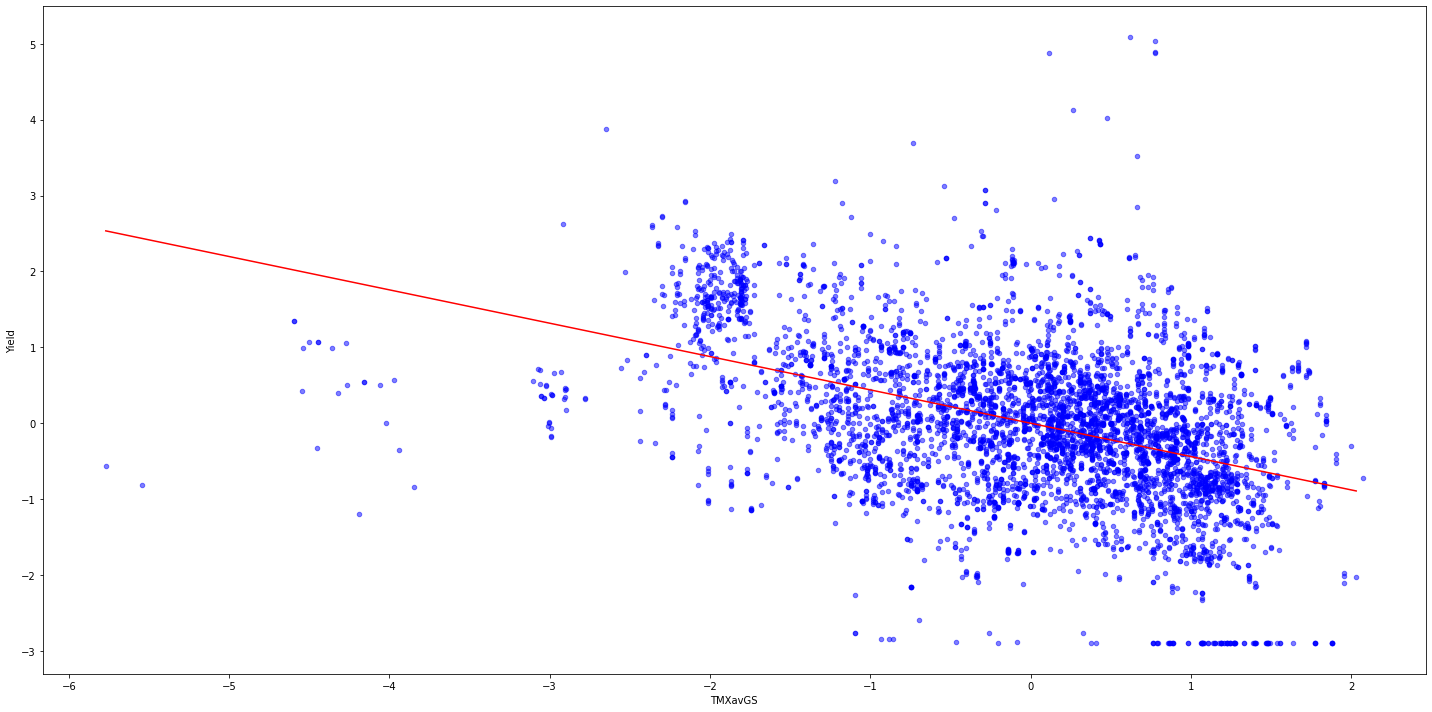

In [110]:
#Visualisng the polynomial regression model results
plt.figure(figsize = (20,10))
predictor = "TMXavGS"
plt.scatter(X_train[:, -2],y_train,color='blue', s = 20, alpha = .5)
plt.xlabel(predictor)
plt.ylabel('Yield')
plt.tight_layout()
# plt.scatter(X_test[:, 3], predictions,color='red')
x = np.arange(X_train[:, -2].min(), X_train[:, -2].max(), .1)
y = (-0.4393525051053428)*x
plt.plot(x, y, color = "red")

In [137]:
a = polyreg.named_steps['poly'].powers_
# b = [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
# np.where(np.all(a==b,axis=1))

In [138]:
a[44, :]
# print(list(polyreg.named_steps['lr'].coef_[0])[10])

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [125]:
np.argsort([np.abs(val) for val in list(polyreg.named_steps['lr'].coef_[0])])[-10:]

array([ 6, 22, 70, 58, 42, 44, 77,  4,  8, 10])

In [802]:
#### NEAREST NEIGHBORS

# pull hold out columns - column of response variable and columns too tightly tied to response variable
# explore_vars = ['SimUID', 'YR', 'CMD', 'PET', 'VPD', 'TMX', 'TMN', 'RAD', "PRCP"]
explore_vars = ['SimUID', 'YR', 'OC', 'SAND', 'SILT', 'CLAY', 'BD', 'HSG', 'CEC', 'SOB', 'PH', 'KS', 'WP', 'FWC']

non_corr_cols = [col for col in predictor_data.columns if not any(var in col for var in explore_vars)]

# match on variables that you're note exploring!
NN_df = predictor_data[non_corr_cols]

#### BIG QUESTION: ARE THERE ACTUALLY RESPONSE CURVES WE CAN PULL OUT THAT ARE NON RANDOM 

# use KNN matching to get subsets of the EPIC runs to build response curves from 
# import NN package
from sklearn.neighbors import NearestNeighbors

# set NN to 20, we can test this parameter as we go
NN = NearestNeighbors(n_neighbors=1400)
NN.fit(NN_df)

test_pts = NN_df.iloc[89734].to_numpy().reshape(1, -1)

# test out pulling nearest neighbors - try with N experiments to ensure that NN is working 
n_dist, n_ind = NN.kneighbors(test_pts)

In [50]:
all_data.PRCPskGS.mean()

0.51808937536882

In [84]:
## plot some response curves
# sort 
x = np.array(cluster['PRCPsumGS'])
y = np.array(cluster['YLDG'])
order = np.argsort(x)
x_ = x[order].reshape(-1,1)
y_ = y[order].reshape(-1,1)
x_plot = x[order]
y_plot = y[order]

In [85]:
# create polynomial features
poly_reg=PolynomialFeatures(degree=2)
# fit to x data 
X_poly=poly_reg.fit_transform(x_)

# create a linear regression 
lin_reg2=linear_model.LinearRegression()
# feed it the polynomial data
lin_reg2.fit(X_poly,y_)
# predict 
predicted = lin_reg2.predict(X_poly)

score = lin_reg2.score(X_poly, y_)
score

0.3316201541972882

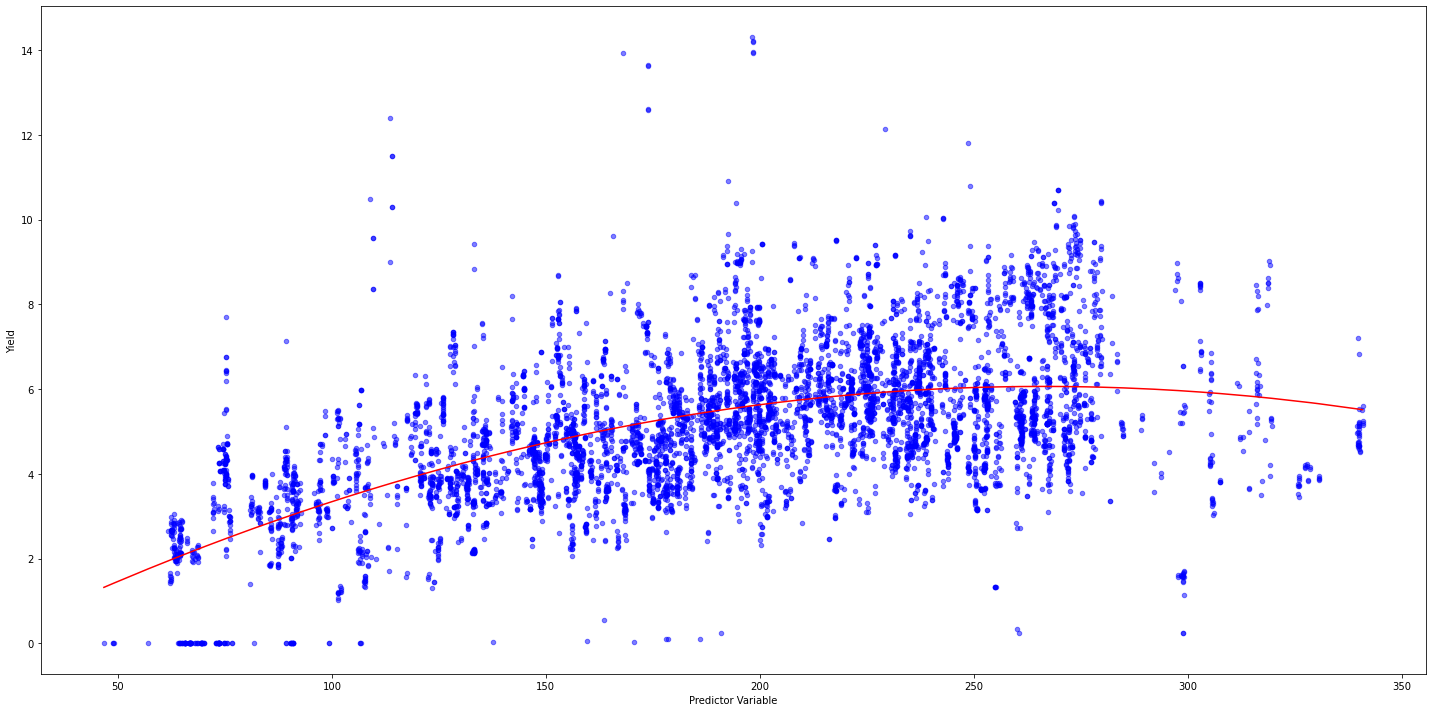

In [86]:
#Visualisng the polynomial regression model results
plt.figure(figsize = (20,10))
plt.scatter(x_,y_,color='blue', s = 20, alpha = .5)
plt.xlabel("Predictor Variable")
plt.ylabel('Yield')
plt.tight_layout()
plt.plot(x_,predicted,color='red')

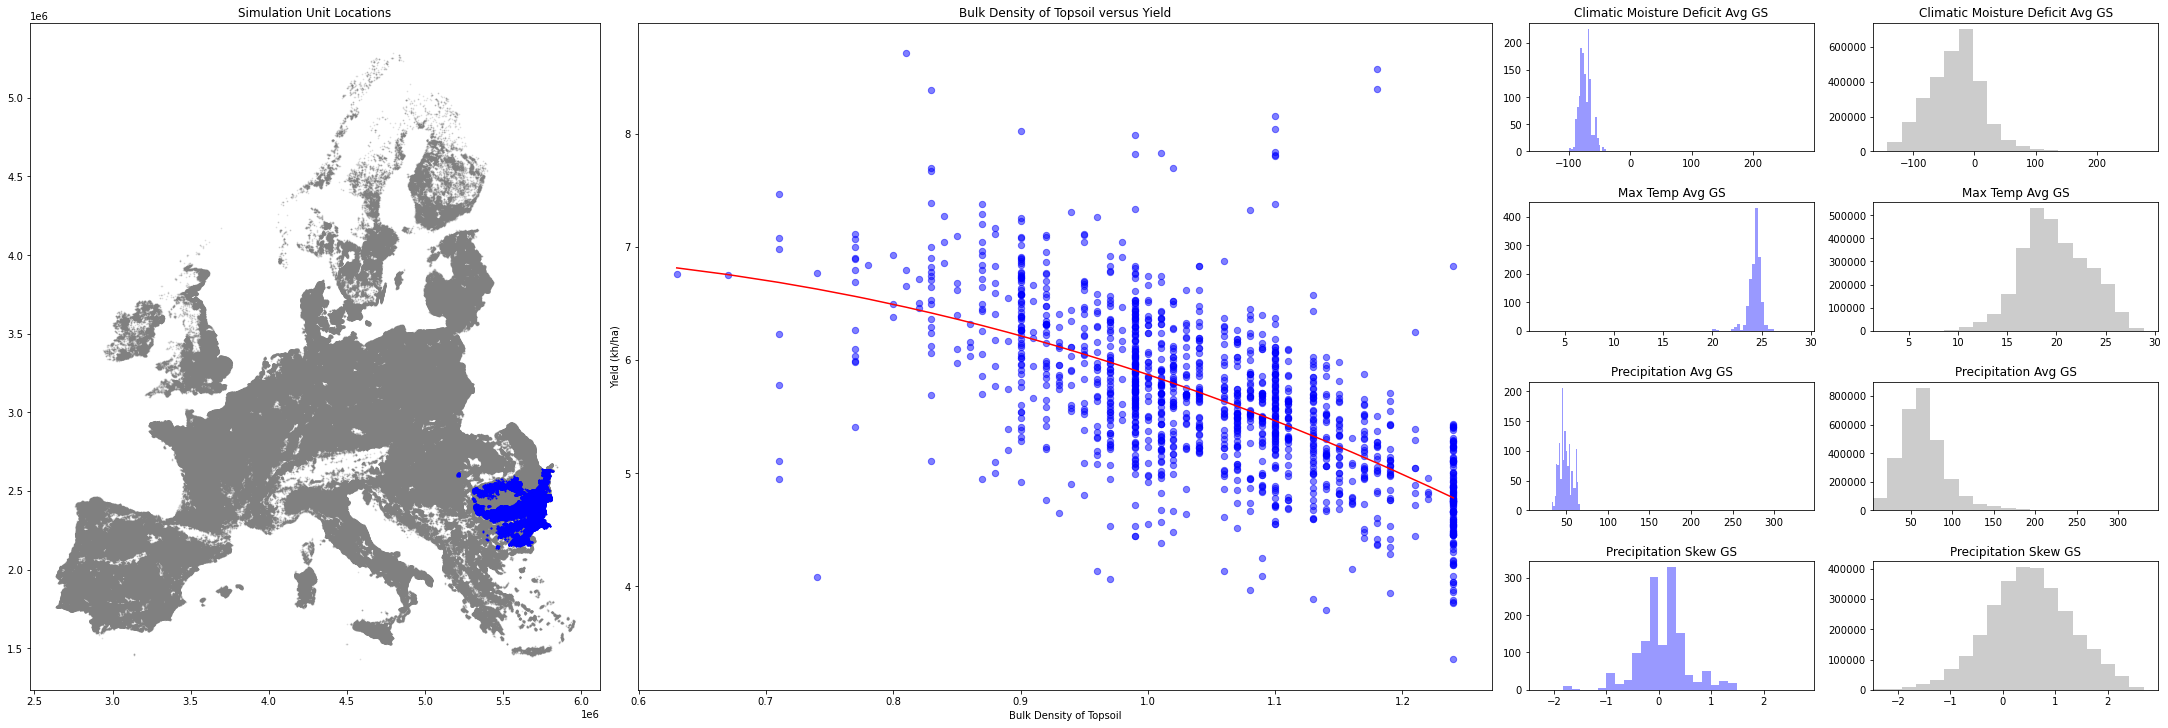

In [862]:
pulled_pts = loc[loc.SimUID.isin(list(all_data.iloc[n_ind[0]].SimUID.unique()))]

fig = plt.figure(figsize = (30,10), constrained_layout=True)
axs = fig.subplot_mosaic([['LeftLeft', 'Left', 'TopCenter', 'TopRight'],
                          ['LeftLeft', 'Left', 'MiddleCenter', 'MiddleRight'],
                          ['LeftLeft', 'Left', 'BottomCenter', 'BottomRight'],
                          ['LeftLeft', 'Left', 'VBottomCenter', 'VBottomRight']],
                          gridspec_kw={'width_ratios':[2,3,1,1]})

axs['LeftLeft'].set_title("Simulation Unit Locations")
axs['LeftLeft'].scatter(loc['X'], loc["Y"], s= .5, c = "grey", edgecolor = None, alpha = .2)
axs['LeftLeft'].scatter(pulled_pts['X'], pulled_pts['Y'], s = 1, c = "blue", edgecolor = None, alpha = 1)

axs['Left'].set_title('Bulk Density of Topsoil versus Yield')
axs['Left'].scatter(x_,y_,color='blue', s = 40, alpha = .5)
axs['Left'].plot(x_,predicted,color='red')
axs['Left'].set_xlabel("Bulk Density of Topsoil")
axs['Left'].set_ylabel('Yield (kh/ha)')

# data for histograms 
NN_data = all_data.iloc[n_ind[0]]

axs['TopCenter'].set_title('Climatic Moisture Deficit Avg GS')
axs['TopCenter'].hist(NN_data['CMDavGS'], bins = 20, color = 'blue', alpha = .4)
axs['TopCenter'].set_xlim([all_data['CMDavGS'].min(), all_data['CMDavGS'].max()])

axs['MiddleCenter'].set_title('Max Temp Avg GS')
axs['MiddleCenter'].hist(NN_data['TMXavGS'], bins = 20, color = 'blue', alpha = .4)
axs['MiddleCenter'].set_xlim([all_data['TMXavGS'].min(), all_data['TMXavGS'].max()])

axs['BottomCenter'].set_title('Precipitation Avg GS')
axs['BottomCenter'].hist(NN_data['PRCPavGS'], bins = 20, color = 'blue', alpha = .4)
axs['BottomCenter'].set_xlim([all_data['PRCPavGS'].min(), all_data['PRCPavGS'].max()])

axs['VBottomCenter'].set_title('Precipitation Skew GS')
axs['VBottomCenter'].hist(NN_data['PRCPskGS'], bins = 20, color = 'blue', alpha = .4)
axs['VBottomCenter'].set_xlim([all_data['PRCPskGS'].min(), all_data['PRCPskGS'].max()])

axs['TopRight'].set_title('Climatic Moisture Deficit Avg GS')
axs['TopRight'].hist(all_data['CMDavGS'], bins = 20, color = 'grey', alpha = .4)
axs['TopRight'].set_xlim([all_data['CMDavGS'].min(), all_data['CMDavGS'].max()])

axs['MiddleRight'].set_title('Max Temp Avg GS')
axs['MiddleRight'].hist(all_data['TMXavGS'], bins = 20, color = 'grey', alpha = .4)
axs['MiddleRight'].set_xlim([all_data['TMXavGS'].min(), all_data['TMXavGS'].max()])

axs['BottomRight'].set_title('Precipitation Avg GS')
axs['BottomRight'].hist(all_data['PRCPavGS'], bins = 20, color = 'grey', alpha = .4)
axs['BottomRight'].set_xlim([all_data['PRCPavGS'].min(), all_data['PRCPavGS'].max()])

axs['VBottomRight'].set_title('Precipitation Skew GS')
axs['VBottomRight'].hist(all_data['PRCPskGS'], bins = 20, color = 'grey', alpha = .4)
axs['VBottomRight'].set_xlim([all_data['PRCPskGS'].min(), all_data['PRCPskGS'].max()])

plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//Figures//1400NN_soil_droughtGOOD2.jpg")

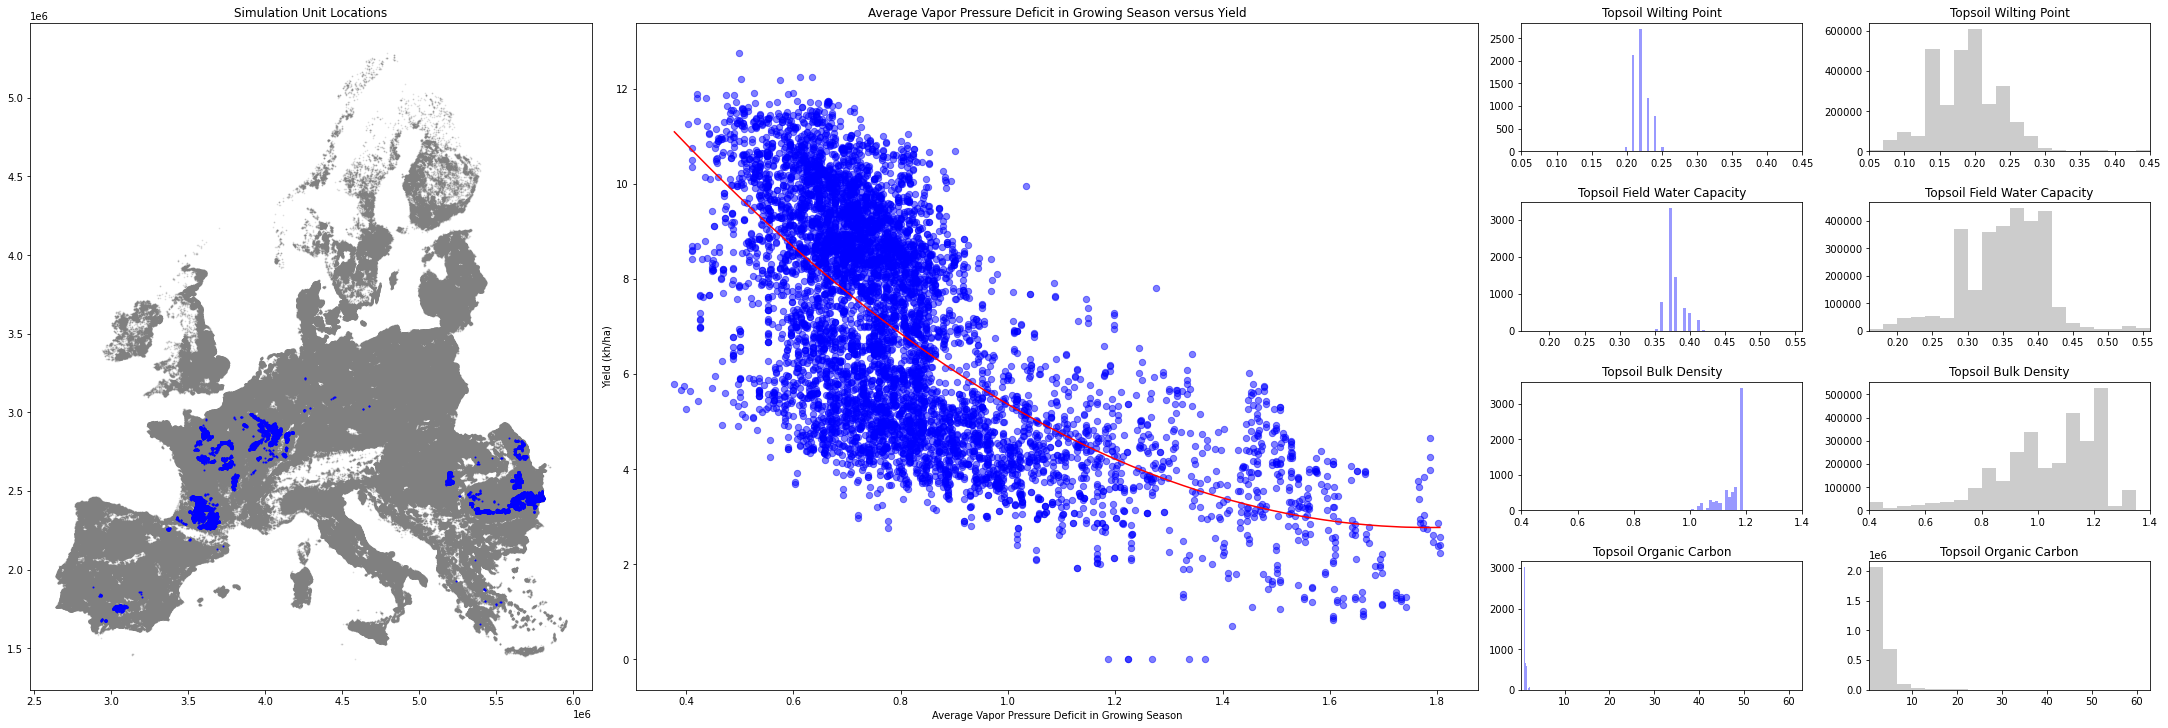

In [561]:
clim_var = "FWC_SUB"
pulled_pts = loc[loc.SimUID.isin(list(all_data.iloc[n_ind[0]].SimUID.unique()))]

fig = plt.figure(figsize = (30,10), constrained_layout=True)
axs = fig.subplot_mosaic([['LeftLeft', 'Left', 'TopCenter', 'TopRight'],
                          ['LeftLeft', 'Left', 'MiddleCenter', 'MiddleRight'],
                          ['LeftLeft', 'Left', 'BottomCenter', 'BottomRight'],
                          ['LeftLeft', 'Left', 'VBottomCenter', 'VBottomRight']],
                          gridspec_kw={'width_ratios':[2,3,1,1]})

axs['LeftLeft'].set_title("Simulation Unit Locations")
axs['LeftLeft'].scatter(loc['X'], loc["Y"], s= .5, c = "grey", edgecolor = None, alpha = .2)
axs['LeftLeft'].scatter(pulled_pts['X'], pulled_pts['Y'], s = 1, c = "blue", edgecolor = None, alpha = 1)

axs['Left'].set_title('Average Vapor Pressure Deficit in Growing Season versus Yield')
axs['Left'].scatter(x_,y_,color='blue', s = 40, alpha = .5)
axs['Left'].plot(x_,predicted,color='red')
axs['Left'].set_xlabel("Average Vapor Pressure Deficit in Growing Season")
axs['Left'].set_ylabel('Yield (kh/ha)')

# data for histograms 
NN_data = all_data.iloc[n_ind[0]]

axs['TopCenter'].set_title('Topsoil Wilting Point')
axs['TopCenter'].hist(NN_data['WP_TOP'], bins = 20, color = 'blue', alpha = .4)
axs['TopCenter'].set_xlim([all_data['WP_TOP'].min(), all_data['WP_TOP'].max()])

axs['MiddleCenter'].set_title('Topsoil Field Water Capacity')
axs['MiddleCenter'].hist(NN_data['FWC_TOP'], bins = 20, color = 'blue', alpha = .4)
axs['MiddleCenter'].set_xlim([all_data['FWC_TOP'].min(), all_data['FWC_TOP'].max()])

axs['BottomCenter'].set_title('Topsoil Bulk Density')
axs['BottomCenter'].hist(NN_data['BD_TOP'], bins = 20, color = 'blue', alpha = .4)
axs['BottomCenter'].set_xlim([all_data['BD_TOP'].min(), all_data['BD_TOP'].max()])

axs['VBottomCenter'].set_title('Topsoil Organic Carbon')
axs['VBottomCenter'].hist(NN_data['OC_TOP'], bins = 20, color = 'blue', alpha = .4)
axs['VBottomCenter'].set_xlim([all_data['OC_TOP'].min(), all_data['OC_TOP'].max()])

axs['TopRight'].set_title('Topsoil Wilting Point')
axs['TopRight'].hist(all_data['WP_TOP'], bins = 20, color = 'grey', alpha = .4)
axs['TopRight'].set_xlim([all_data['WP_TOP'].min(), all_data['WP_TOP'].max()])

axs['MiddleRight'].set_title('Topsoil Field Water Capacity')
axs['MiddleRight'].hist(all_data['FWC_TOP'], bins = 20, color = 'grey', alpha = .4)
axs['MiddleRight'].set_xlim([all_data['FWC_TOP'].min(), all_data['FWC_TOP'].max()])

axs['BottomRight'].set_title('Topsoil Bulk Density')
axs['BottomRight'].hist(all_data['BD_TOP'], bins = 20, color = 'grey', alpha = .4)
axs['BottomRight'].set_xlim([all_data['BD_TOP'].min(), all_data['BD_TOP'].max()])

axs['VBottomRight'].set_title('Topsoil Organic Carbon')
axs['VBottomRight'].hist(all_data['OC_TOP'], bins = 20, color = 'grey', alpha = .4)
axs['VBottomRight'].set_xlim([all_data['OC_TOP'].min(), all_data['OC_TOP'].max()])

plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//Figures//7000NN_clim.jpg")

## Test response curves with EPIC experiments - site specific 

## Subgroup Discovery using Principal Component Analysis and k-means clustering 
### biophysical subgroups based on soil and climate
Test Subgroup discovery with full dataset, with principal components, with just climate, and with just soil data

In [24]:
df = pd.read_csv("//Users//taraippolito//Desktop//EPIC_local//_SimUData//SimU_plus_clim.csv").dropna()
df.name = "Simulation_Units_Soil_and_Climate"

In [25]:
SimU_loc = pd.read_csv("//Users//taraippolito//Desktop//EPIC_local//SimUID_Pts_210_240.txt", sep = ",")

## PCA

In [26]:
# PCA ANALYSIS

def PCA_fxn(df_full, subset):
    # plotting variables
    plot_title = (df_full.name).replace("_", " ") + " PCA"
    path = "//Users//taraippolito//Desktop//EPIC_local//_SimUData//" + df_full.name + "_PCA_scatter.jpg"
    
    # pull out categorical and identifying columns
    remove_cols = ['Unnamed: 0', 'SimUID', 'SimU', 'NUTS2', 'LCF3', 'HRU', 'ELEV_CAT',
           'SLP_CAT', 'TEXTURE', 'HSG', 'HSG2']
    # climate columns and soil columns
    clim_cols = [col for col in df_full.columns if "PET" in col or "PRCP" in col or "RAD" in col or "RAD" in col or "TMN" in col or "TMX" in col or "VPD" in col]
    soil_cols = [col for col in df_full.columns if col not in clim_cols and col not in remove_cols]
    
    # columns to use for PCA analysis 
    if subset == "all": 
        vars_for_PCA = [col for col in df_full.columns if col not in remove_cols]        
    if subset == "climate":
        vars_for_PCA = clim_cols
    if subset == "soil":
        vars_for_PCA = soil_cols
    
    # pull variables from original df 
    df = df_full[vars_for_PCA]

    # instantiate scaler
    scaler = StandardScaler()
    # fit and transform data 
    scaled_df = scaler.fit_transform(df)
    scaled_features_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)
    
    # instantiate PCA 
    pca = PCA(n_components = .90)
    # fit to scaled data
    pca.fit(scaled_df)
    # projected data 
    projected = pca.transform(scaled_df)
        
    # return explained variance ratio and components
    return (projected, pca.explained_variance_ratio_, pca.components_, pca.explained_variance_, pca.n_components_)

In [5]:
# to look at the drop off in variance explained by components
def scree_plot(name, n_components_, explained_variance_ratio_): 
    PC_values = np.arange(n_components_) + 1
    plt.plot(PC_values, explained_variance_ratio_, 'o-', linewidth=1, color='blue')
    plt.title('Scree Plot ' + name)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.savefig("//Users//taraippolito//Desktop//EPIC_local//_SimUData//" + name + "_scree_plot.jpg")
    plt.close()

In [27]:
# # run PCA for climate
# project_clim, var_ratio_clim, component_clim, var_clim, n_clim = PCA_fxn(df, "climate")

# # run PCA for soils
# project_soil, var_ratio_soil, component_soil, var_soil, n_soil = PCA_fxn(df, "soil")

# run PCA on both together 
project, var_ratio, component, var, n = PCA_fxn(df, "all")

In [28]:
# save projected data from first four components into dataframe
# projected_clim_df = pd.DataFrame(project_clim[:, :], columns = ["clim_comp1", "clim_comp2", "clim_comp3", "clim_comp4", "clim_comp5", "clim_comp6", "clim_comp7", "clim_comp8", "clim_comp9"])
# projected_soil_df = pd.DataFrame(project_soil[:, :], columns = ["soil_comp1", "soil_comp2", "soil_comp3", "soil_comp4", "soil_comp5", "soil_comp6", "soil_comp7", "soil_comp8", "soil_comp9", "soil_comp10", "soil_comp11"])
projected_all_df = pd.DataFrame(project[:, :], columns = ["comp1", "comp2", "comp3", "comp4", "comp5", "comp6", "comp7", "comp8", "comp9", "comp10"])

In [29]:
# # merge projected columns just climate data to original dataframe
# merged_clim = pd.concat([df.reset_index(drop=True), projected_clim_df.reset_index(drop=True)], axis=1)

# # merge projected columns just soil data to original dataframe
# merged_soil = pd.concat([df.reset_index(drop=True), projected_soil_df.reset_index(drop=True)], axis=1)

# merge projected columns with ALL data to original dataframe
merged_all = pd.concat([df.reset_index(drop=True),projected_all_df.reset_index(drop=True)], axis=1)


In [30]:
# functions to pull appropriate columns for clustering 
def no_pca_subset(pair): 
    df = pair[0]
    key = pair[1]
    # remove these from all subsets
    remove_cols = ['Unnamed: 0', 'SimU', 'NUTS2', 'LCF3', 'HRU', 'ELEV_CAT',
               'SLP_CAT', 'TEXTURE', 'HSG', 'HSG2']
    comp_cols = [col for col in df.columns if 'comp' in col]
    
    # climate cols 
    clim_cols = [col for col in df.columns if "PET" in col or "PRCP" in col or "RAD" in col or "RAD" in col or "TMN" in col or "TMX" in col or "VPD" in col]

    if key == "all":
        use_these = [col for col in df.columns if col not in remove_cols and col not in comp_cols]
    elif key == "clim":
        use_these = clim_cols 
    elif key == "soil":
        use_these = [col for col in df.columns if col not in clim_cols and col not in remove_cols and col not in comp_cols]

    return(df[use_these])

def pca_subset(df): 
    comp_cols = [col for col in df.columns if 'comp' in col]
    comp_cols.append("SimUID")
    
    return(df[comp_cols])

In [31]:
# subsets = [(merged_all, "all"), (merged_clim, "clim"), (merged_soil, "soil")]
subsets = [(merged_all, "all")]
no_pca = []
pca_only = []
for s in subsets: 
    no_pca.append(no_pca_subset(s))
    pca_only.append(pca_subset(s[0]))

## Clustering

Calculate clusters with all of the features - for climate, soil, and all data subsets 

Calculate clusters with PCA features only - for climate, soil, and all data subsets 

    Calculater clusters of differing sizes - 4 to 12 clusters 
    
        For each cluster size, calculate metrics that measure performance of clusters (e.g. closeness)

In [63]:
def get_clusters(df_in, name): 
    # metrics to save 
    inertia = []
    SC = []
    CHS = []
    DBS = []
    
    df = df_in.drop("SimUID", axis = 1)
    
    # compute clusters for n = 4 - 12
    for i in range(4,13): 
        kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
        kmeans_pca.fit(df)
        
        # save metrics
        inertia.append(kmeans_pca.inertia_)
        SC.append(sklearn.metrics.silhouette_score(df, kmeans_pca.labels_, metric='euclidean'))
        CHS.append(sklearn.metrics.calinski_harabasz_score(df, kmeans_pca.labels_))
        DBS.append(sklearn.metrics.davies_bouldin_score(df, kmeans_pca.labels_))
        
        # update user
        print (name, " ", i, " metrics done.")
        
        # save labels
        df_in["k_mean_cluster"] = kmeans_pca.labels_
        
        # plot map 
        # merge with location data 
        # dataset with all simulation unit information including geospatial info 
        full_df = pd.merge(df_in, SimU_loc, how = "left", left_on = "SimUID", right_on = "SimUID")
        
        title = "Simulation Centroids by cluster - " + str(i) + " clusters, " + name.replace("_", " ")
        plt.figure(figsize = (10,8))
        plt.scatter(full_df['X'], full_df["Y"], s= .5, c = full_df.k_mean_cluster ,edgecolor = None, alpha = 1)
        plt.title(title)
        plt.savefig("//Users//taraippolito//Desktop//EPIC_local//_SimUData//SimU_by_clust_" + str(i) + "_" + name + ".jpg")
        
        # update user
        print (name, " ", i, " map done.")
        
    # plot for data cluster performance 
    output = "//Users//taraippolito//Desktop//EPIC_local//_SimUData//cluster_perf_" + name + ".jpg"
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    axs[0, 0].plot(range(4,13), inertia, marker = "o", linestyle = '--')
    axs[0, 0].set_title('K vs Inertia')
    
    axs[0, 1].plot(range(4,13), SC, marker = "o", linestyle = '--')
    axs[0, 1].set_title('K vs Silhouette Score')
    
    axs[1, 0].plot(range(4,13), CHS, marker = "o", linestyle = '--')
    axs[1, 0].set_title('K vs Calinski-Harbabasz Score')
    
    axs[1, 1].plot(range(4,13), DBS, marker = "o", linestyle = '--')
    axs[1, 1].set_title('K vs Davies-Bouldin Score')
    
    plt.xlabel("k number of clusters")
    plt.ylabel("Score")
    plt.title("K-Means Clustering Performance " + name.replace("_", " "))
    plt.savefig(output)
    plt.close()
    
    # update user
    print (name, " ", i, " done.")

all_data_PCA   4  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   4  map done.
all_data_PCA   5  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   5  map done.
all_data_PCA   6  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   6  map done.
all_data_PCA   7  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   7  map done.
all_data_PCA   8  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   8  map done.
all_data_PCA   9  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   9  map done.
all_data_PCA   10  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   10  map done.
all_data_PCA   11  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   11  map done.
all_data_PCA   12  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


all_data_PCA   12  map done.
all_data_PCA   12  done.
climate_data_PCA   4  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   4  map done.
climate_data_PCA   5  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   5  map done.
climate_data_PCA   6  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   6  map done.
climate_data_PCA   7  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   7  map done.
climate_data_PCA   8  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   8  map done.
climate_data_PCA   9  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   9  map done.
climate_data_PCA   10  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   10  map done.
climate_data_PCA   11  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   11  map done.
climate_data_PCA   12  metrics done.


/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_6745/3877172193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["k_mean_cluster"] = kmeans_pca.labels_


climate_data_PCA   12  map done.
climate_data_PCA   12  done.


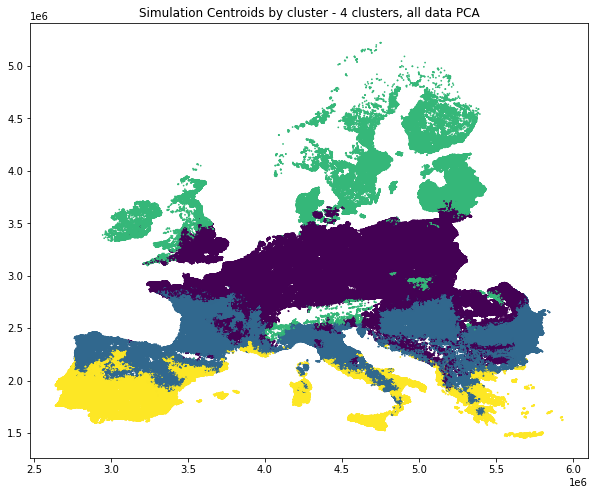

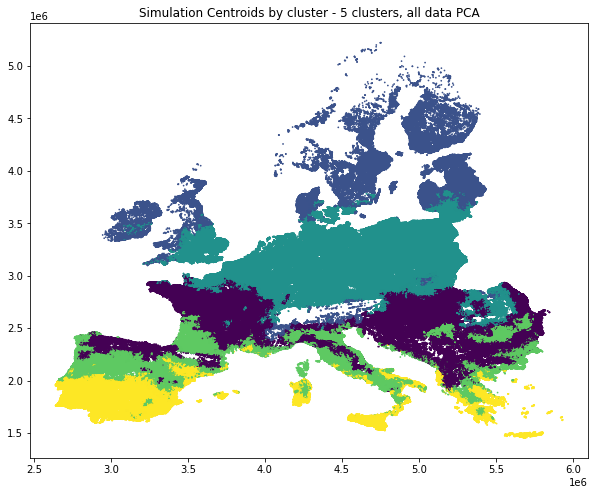

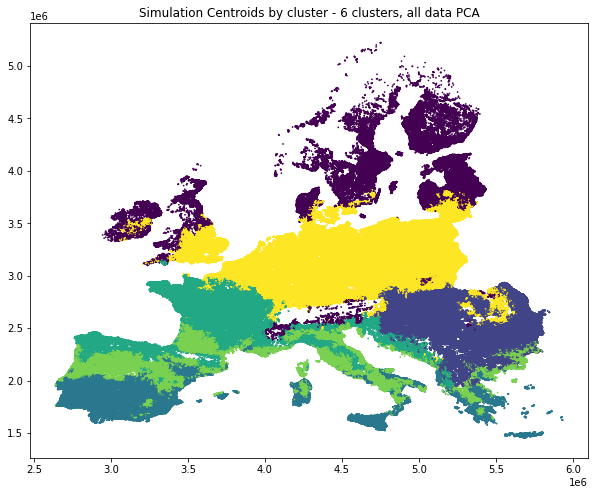

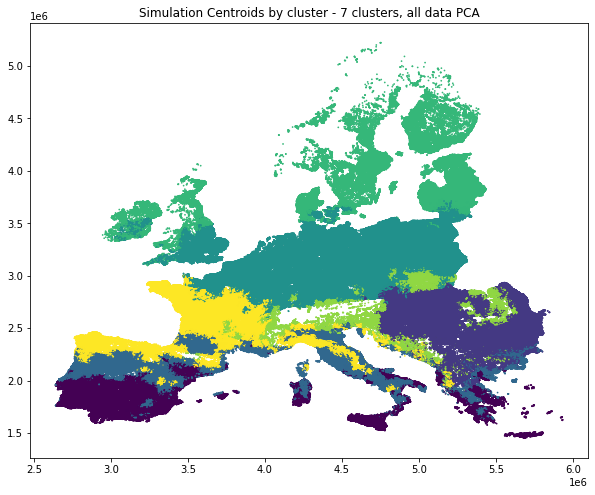

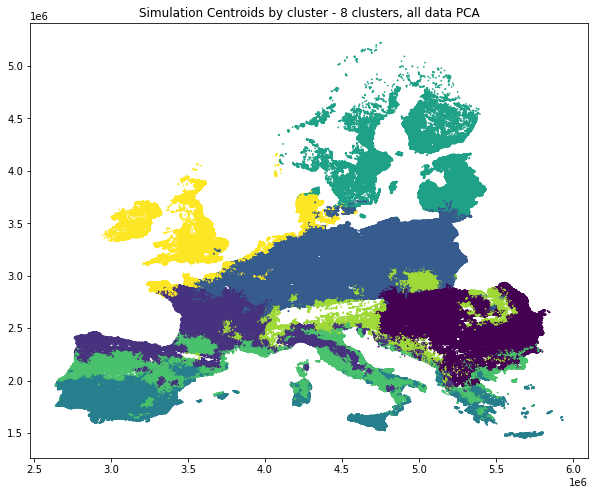

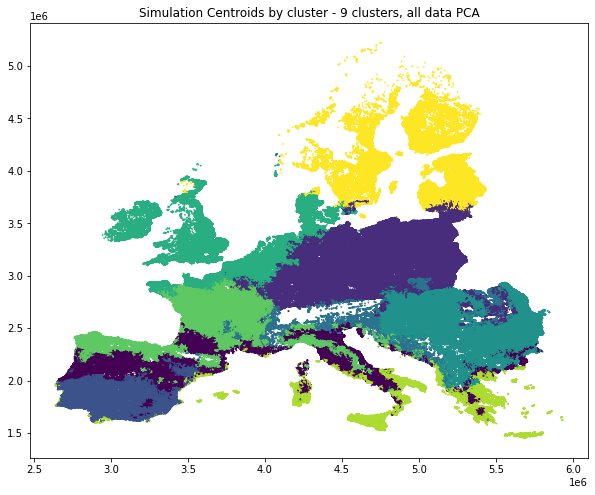

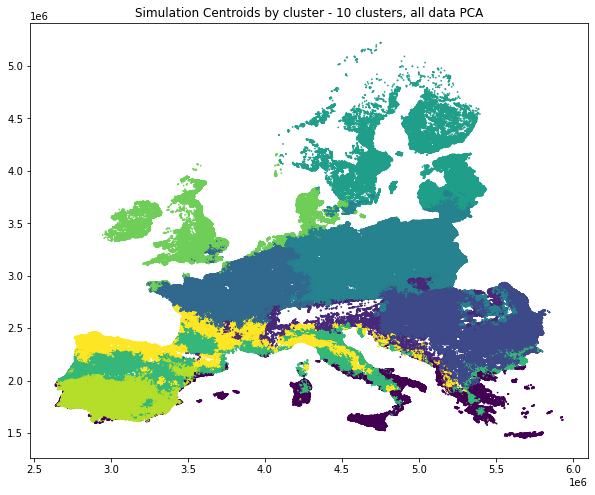

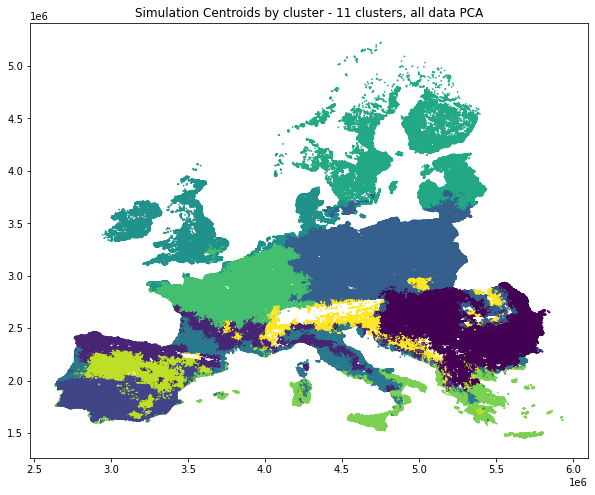

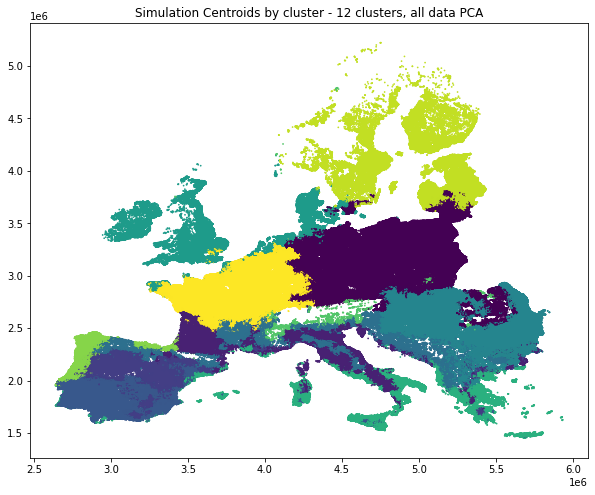

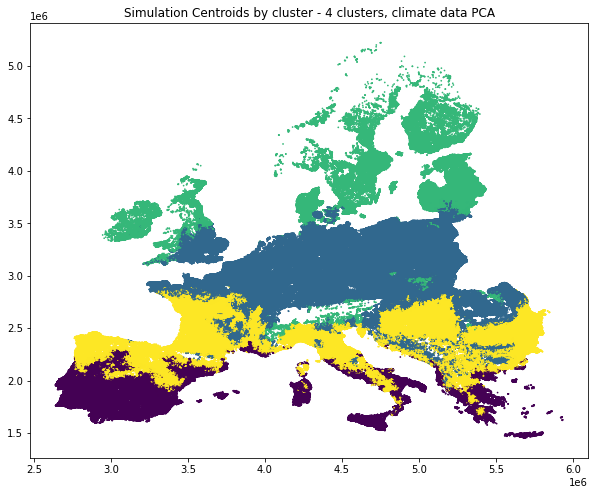

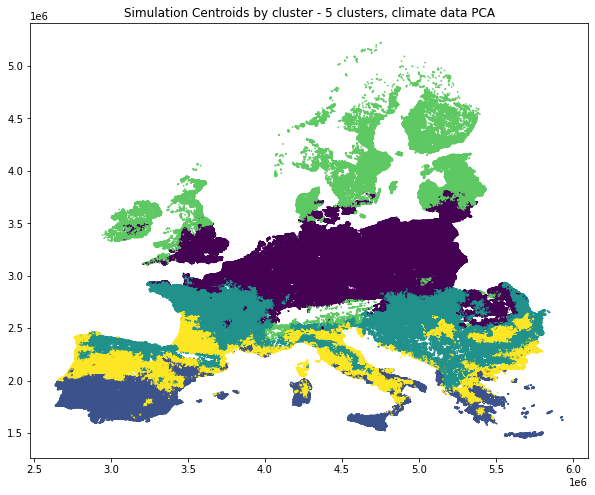

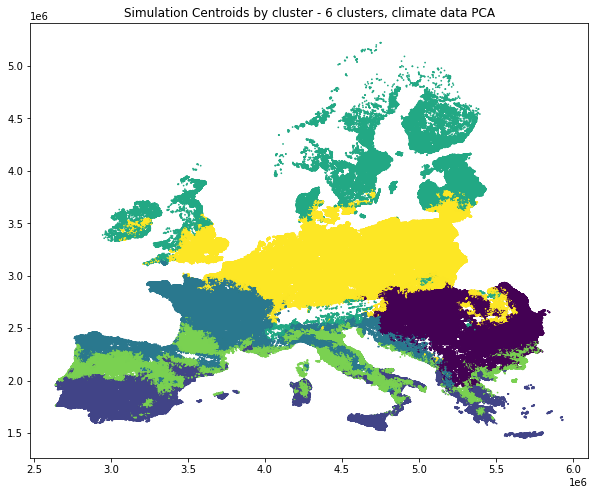

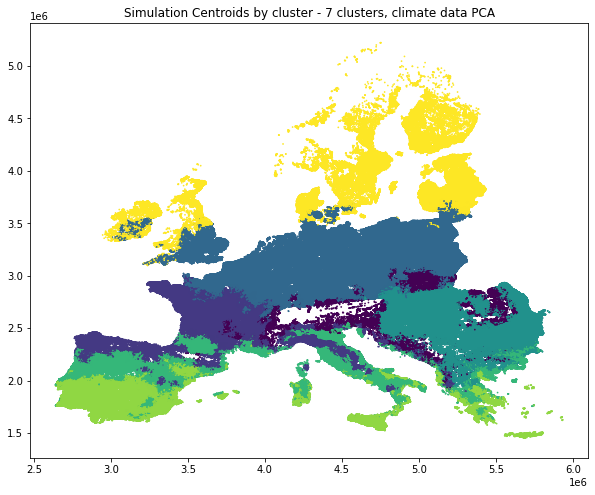

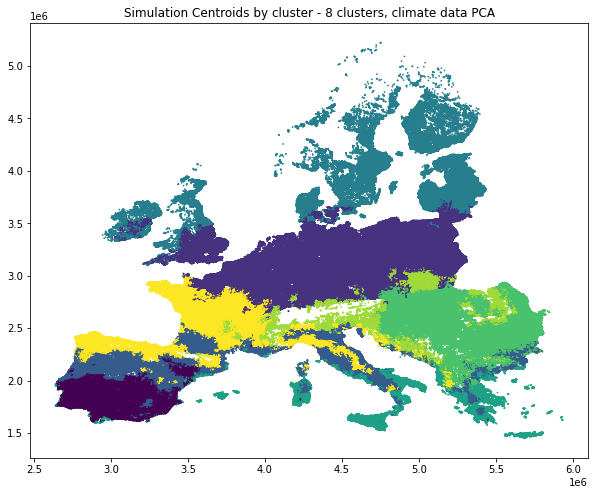

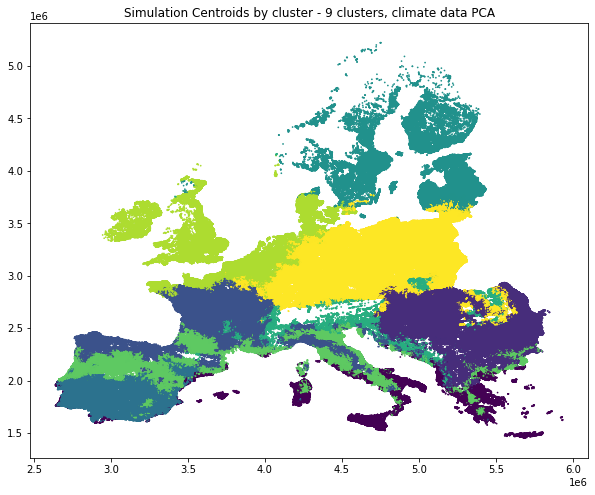

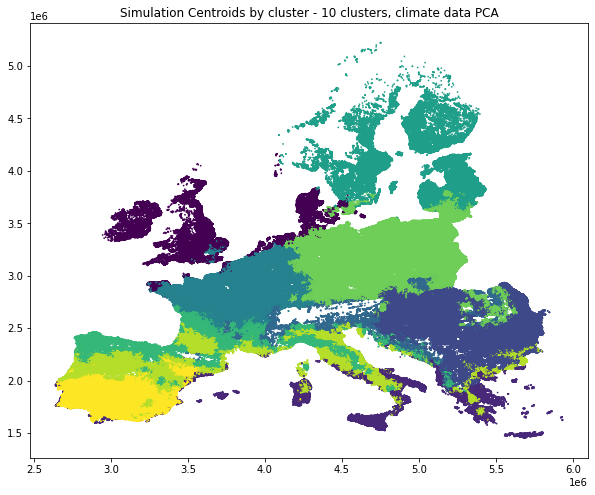

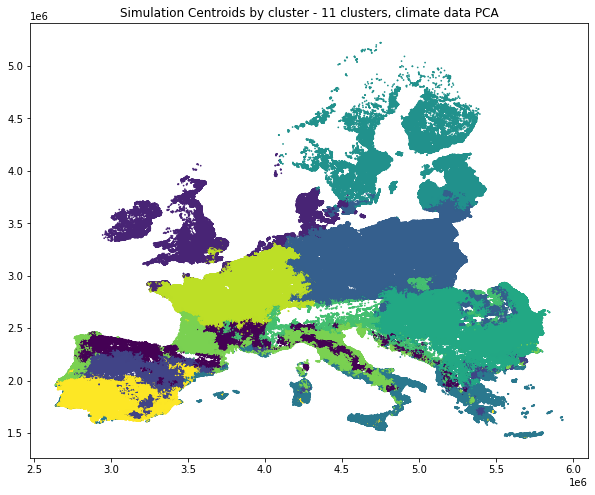

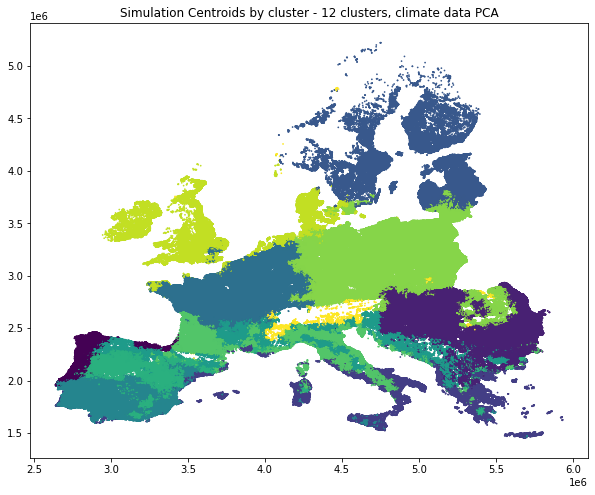

In [65]:
get_clusters(pca_only[0], "all_data_PCA")
get_clusters(pca_only[1], "climate_data_PCA")

## Build clusters with all data and 8 clusters based on metrics from PCA clustering

In [32]:
# only feed PCA columns into clustering
full_df = pca_only[0]
cluster_input = full_df.drop("SimUID", axis = 1)

# complete clusters 
kmeans_pca = KMeans(n_clusters = 8, init = "k-means++", random_state = 42)
kmeans_pca.fit(cluster_input)
# add cluster label 
full_df["k_mean_cluster"] = kmeans_pca.labels_
SC = sklearn.metrics.silhouette_score(cluster_input, kmeans_pca.labels_, metric='euclidean')
CHS = sklearn.metrics.calinski_harabasz_score(cluster_input, kmeans_pca.labels_)
DBS = sklearn.metrics.davies_bouldin_score(cluster_input, kmeans_pca.labels_)
inertia = kmeans_pca.inertia_

# dataset with all simulation unit information including geospatial info 
output = pd.merge(full_df, SimU_loc, how = "inner", left_on = "SimUID", right_on = "SimUID")

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_13758/3960031679.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df["k_mean_cluster"] = kmeans_pca.labels_


In [14]:
print ("Silhouette Score: ", SC, " higher is better")
print ("Calinski Harabasz Score: ", CHS, " higher is better")
print ("Davies Bouldin Score: ", DBS, " min = 0, lower is better")
print ("Inertia Score: ", inertia, " min = 0, lower is better")

Silhouette Score:  0.2615272132189617  higher is better
Calinski Harabasz Score:  38149.52105051188  higher is better
Davies Bouldin Score:  1.2543746776512137  min = 0, lower is better
Inertia Score:  60060350.49736883  min = 0, lower is better


In [39]:
# output.to_csv('//Users//taraippolito//Desktop//EPIC_local//_SimUData//SimU_all_pts_w_pca_comp&clust.csv')

In [34]:
# pull back in all the other columns, leave out latitude and longitutde
ALL = pd.merge(df, full_df, how = "left", left_on = "SimUID", right_on = "SimUID")
# ALL.to_csv("//Users//taraippolito//Desktop//EPIC_local//_SimUData//SimU_w_clim_pca_clust.csv")

## Plotting 

Text(0.5, 1.0, 'Simulation Centroids by PCA component cluster')

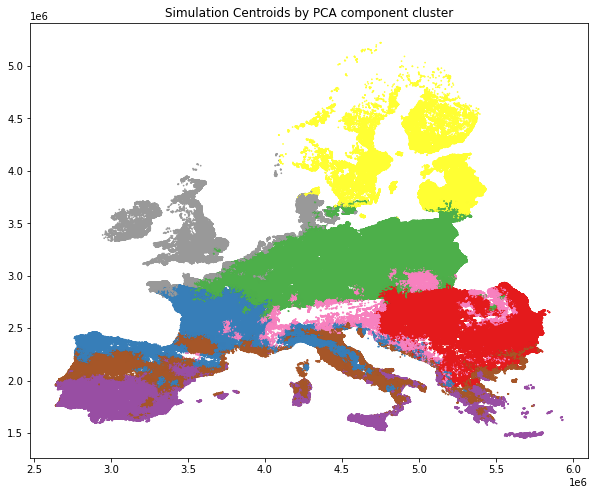

In [17]:
title = "Simulation Centroids by PCA component cluster"
cmap = matplotlib.cm.get_cmap("Set1")
plt.figure(figsize = (10,8))
plt.scatter(output['X'], output["Y"], s= .5, c = output.k_mean_cluster ,cmap = cmap, edgecolor = None, alpha = 1)
plt.title(title)
# plt.savefig("//Users//taraippolito//Desktop//EPIC_local//_SimUData//SimU_by_clust_8_all_data_PCA.jpg")

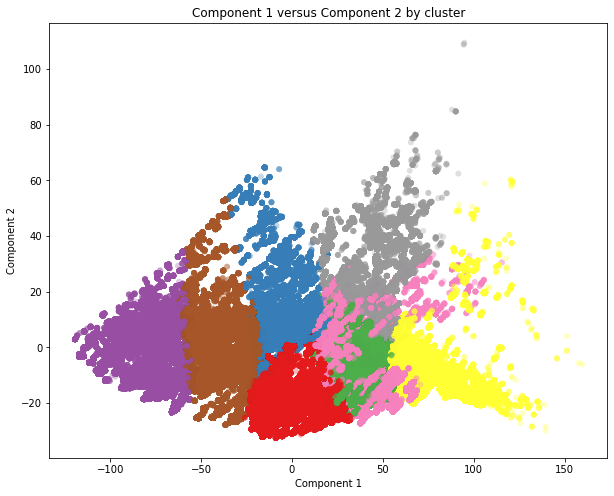

In [16]:
title = "Component 1 versus Component 2 by cluster"
cmap = matplotlib.cm.get_cmap("Set1")
plt.figure(figsize = (10,8))
plt.scatter(output["comp1"], output["comp2"],
         c = output.k_mean_cluster ,cmap = cmap, edgecolor='none', alpha=0.3,)
plt.title(title)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig("//Users//taraippolito//Desktop//EPIC_local//_SimUData//PC1_PC2_by_PCA_cluster.jpg")

## Bayesian Additive Regression Trees 
Build out framework for taking a specific CROP x N x RESIDUE scenario and building BART 

First, set up the data needed by merging records from csv files which contain:

1. simulation unit weather and site data, PCA components, and cluster

2. CROP x N x RESIDUE x SIMU x YEAR simulations of crop growth containing monthly and annual variables 

Then, separate into train-test-split groups

Finally, build BART where each data point is one EPIC simulation at a given point in a given year under the CROP x N x RESIDUE specifications 



### PREP DATA - merge static data to run data by SimUID x YR 

In [5]:
# DEFINE FUNCTION FOR PULLING ALL MONTHLY DATA TOGETHER FOR A GIVEN FOR EACH SIMU x YEAR
def all_run_data(crop, nitr, res): 
    # import statements for parallen processing
#     import os 
#     import pandas as pd
    
    # first pull all of the necessary data 
    # pull all variable names which will get linked to annual metrics 
    file_names = os.listdir("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//" + crop)
    # pull specific variable names - using N100 just to pull variable names 
    variables = [f[21:-4] for f in [file for file in file_names if "N100" in file]]
    # pull files for specific nitrogen and residues 
    crop_nitr_res_files = [file for file in file_names if nitr in file and res in file]
    
    # starter dataframe = yearly measurement dataframe
    start_file = [file for file in crop_nitr_res_files if "ACY" in file][0]
    start_path = os.path.join(("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//" + crop), start_file)
    start = pd.read_csv(start_path)
    # placeholder of dataframe so it updates iteratively
    merge_me = start
    # take out the annual file as a variable now that we have that file used already 
    variables.remove("ACY")
    
    # make a large wide dataframe with all monthly variables and annual variables 
    # loop over all other variables and append to the annual output variables
    
    print ("starting variable loop.")
    for var in variables: 
        add_file = [file for file in crop_nitr_res_files if var in file][0]
        add_path = os.path.join(("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//" + crop), add_file)
        # open the file 
        add = pd.read_csv(add_path)
        print (var, " open.")
        
        # reformat so the variables are in the column names 
        wide_df = add.pivot(columns=['VAR'], values=['SimUID', 'YR', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'AGG'])
        # fix column names
        wide_df.columns = wide_df.swaplevel(axis='columns').columns.to_flat_index().map('_'.join)
        # reset index
        wide_df.reset_index(inplace = True)
        wide_df.rename(columns={(var + '_SimUID'):'SimUID', (var + '_YR'):'YR'}, inplace=True) 
        
        # then join this to the starting dataframe 
        merged = pd.merge(merge_me, wide_df, how = "left", left_on = ["SimUID", "YR"], right_on = ["SimUID", "YR"])
        # drop index column 
        merged.drop("index", axis = 1, inplace = True)
        print (merged.columns)
        # update dataframe to merge
        merge_me = merged
        
        print (var, " merged.")
        
    # change index to simUID 
    return_df = merged.set_index('SimUID')
    
    # return the fully merged dataframe at the end
    return (return_df)

In [6]:
# SET UP THE DATA 
# define which crop, nitrogen, and residue settings you want to explore 
C = "CORN" 
N = "N01" 
R = "R00" 

In [7]:
c_n01_r00 = all_run_data(C,N,R)

starting variable loop.
TOC  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN', 'TOC_FEB', 'TOC_MAR', 'TOC_APR', 'TOC_MAY', 'TOC_JUN',
       'TOC_JUL', 'TOC_AUG', 'TOC_SEP', 'TOC_OCT', 'TOC_NOV', 'TOC_DEC',
       'TOC_AGG'],
      dtype='object')
TOC  merged.
FNO3  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN', 'TOC_FEB', 'TOC_MAR', 'TOC_APR', 'TOC_MAY', 'TOC_JUN',
       'TOC_JUL', 'TOC_AUG', 'TOC_SEP', 'TOC_OCT', 'TOC_NOV', 'TOC_DEC',
       'TOC_AGG', 'FNO3_JAN', 'FNO3_FEB', 'FNO3_MAR', 'FNO3_APR', 'FNO3_MAY',
       'FNO3_JUN', 'FNO3_JUL', 'FNO3_AUG', 'FNO3_SEP', 'FNO3_OCT', 'FNO3_NOV',
       'FNO3_DEC', 'FNO3_AGG'],
      dtype='object')
FNO3  merged.
OCPD  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN', 'TOC_FEB', 'TOC_MAR', 'TOC_APR', 'TOC_MAY', 'TOC_JUN',
       'TOC_JUL', 'TOC_AUG', 'TOC_SEP', 'TOC_OCT', 'TOC_NOV', 'TOC_DE

Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN',
       ...
       'WS_APR', 'WS_MAY', 'WS_JUN', 'WS_JUL', 'WS_AUG', 'WS_SEP', 'WS_OCT',
       'WS_NOV', 'WS_DEC', 'WS_AGG'],
      dtype='object', length=243)
WS  merged.
BIOM  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN',
       ...
       'BIOM_APR', 'BIOM_MAY', 'BIOM_JUN', 'BIOM_JUL', 'BIOM_AUG', 'BIOM_SEP',
       'BIOM_OCT', 'BIOM_NOV', 'BIOM_DEC', 'BIOM_AGG'],
      dtype='object', length=256)
BIOM  merged.
NS  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN',
       ...
       'NS_APR', 'NS_MAY', 'NS_JUN', 'NS_JUL', 'NS_AUG', 'NS_SEP', 'NS_OCT',
       'NS_NOV', 'NS_DEC', 'NS_AGG'],
      dtype='object', length=269)
NS  merged.
SSF  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'TOC_JAN',
       ...
       'SSF_APR', 'SSF_MAY', 'SSF_JUN', 'S

In [9]:
c_n01_r00.to_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N01_R00_monthly_data.csv")

## Data Viz

In [ ]:
halved_data.reset_index(inplace = True)
# import static data and drop unnecessary columns
lat_lon = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimU_all_pts_w_pca_comp&clust.csv")

In [325]:
mean = halved_data.groupby(halved_data.SimUID).mean()
df = pd.merge(lat_lon, mean, how = 'left', on = "SimUID")

In [326]:
df

Unnamed: 0      comp1      comp2      comp3     comp4      comp5  \
0                 0  54.919971  16.188046  32.914192  7.291776  -5.303040   
1                 1   4.273942 -18.384545  -7.174742  6.758222 -10.323355   
2                 2   4.273942 -18.384545  -7.174742  6.758222 -10.323355   
3                 3   4.273942 -18.384545  -7.174742  6.758222 -10.323355   
4                 4   4.273942 -18.384545  -7.174742  6.758222 -10.323355   
...             ...        ...        ...        ...       ...        ...   
1639511     1639511   8.283604 -17.448924  15.411806  6.432815   1.918465   
1639512     1639512   8.283604 -17.448924  15.411806  6.432815   1.918465   
1639513     1639513   8.283707 -17.465981  15.406070  6.389739   1.914328   
1639514     1639514   8.283707 -17.465981  15.406070  6.389739   1.914328   
1639515     1639515  10.141852 -16.593774  14.806886  7.478445   1.840365   

             comp6      comp7     comp8      comp9  ...  h2_sum_BIOM  \
0        16.326750  12.620921  2.412902  13.362271  ...    47.919706   
1         6.855576   3.874459  1.518889  -2.545647  ...    96.290588   
2         6.855576   3.874459  1.518889  -2.545647  ...    96.290588   
3         6.855576   3.874459  1.518889  -2.545647  ...    96.290588   
4         6.855576   3.874459  1.518889  -2.545647  ...    96.290588   
...            ...        ...       ...        ...  ...          ...   
1639511  -9.440615 -11.116749  7.849888   2.645363  ...    41.900882   
1639512  -9.440615 -11.116749  7.849888   2.645363  ...    41.900882   
1639513  -9.443966 -11.114020  7.826387   2.659332  ...    41.785294   
1639514  -9.443966 -11.114020  7.826387   2.659332  ...    41.785294   
1639515 -11.755833 -10.961758  8.724335   2.502118  ...    40.771176   

         h2_mean_BIOM  h1_sum_NS  h1_mean_NS  h2_sum_NS  h2_mean_NS  \
0           15.973235   0.423824    0.105956   0.127647    0.042549   
1           24.247525   2.356765    0.592157  14.146176    3.593824   
2           24.247525   2.356765    0.592157  14.146176    3.593824   
3           24.247525   2.356765    0.592157  14.146176    3.593824   
4           24.247525   2.356765    0.592157  14.146176    3.593824   
...               ...        ...         ...        ...         ...   
1639511     13.966961  18.947647    4.796201  15.823824    5.274608   
1639512     13.966961  18.947647    4.796201  15.823824    5.274608   
1639513     13.928431  19.710882    4.989534  16.315882    5.438627   
1639514     13.928431  19.710882    4.989534  16.315882    5.438627   
1639515     13.590392  28.190588    7.134387  20.252941    6.750980   

         h1_sum_SSF  h1_mean_SSF  h2_sum_SSF  h2_mean_SSF  
0          3.820000     0.955000    2.295588     0.765196  
1          0.000000     0.000000    0.000000     0.000000  
2          0.000000     0.000000    0.000000     0.000000  
3          0.000000     0.000000    0.000000     0.000000  
4          0.000000     0.000000    0.000000     0.000000  
...             ...          ...         ...          ...  
1639511   12.385000     3.507426    9.621471     3.207157  
1639512   12.385000     3.507426    9.621471     3.207157  
1639513    7.799412     2.223382    5.861765     1.953922  
1639514    7.799412     2.223382    5.861765     1.953922  
1639515    8.003529     2.271593    5.734118     1.911373  

[1639516 rows x 111 columns]

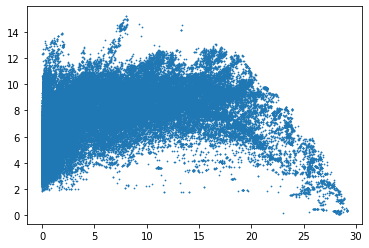

In [314]:
plt.scatter(df.h2_mean_TS, df.YLDG, marker = 'o', s = .5)

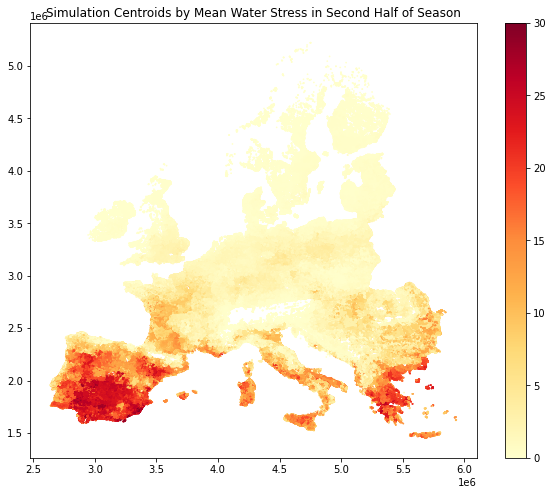

In [332]:
title = "Simulation Centroids by Mean Water S7tress in Second Half of Season"
cmap = matplotlib.cm.get_cmap("YlOrRd")
norm = plt.Normalize(0, 30)
plt.figure(figsize = (10,8))
plt.scatter(df.X, df.Y, s= .5, c = df.h2_mean_WS ,cmap = cmap, edgecolor = None, alpha = 1)
plt.title(title)
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap))
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimU_by_mean_h2WS.jpg")

In [ ]:
#### FIX THIS LATER 
# Calculate annual mean change in carbon 
df = c_bau_r00
TOC_cols = [col for col in df.columns if "TOC" in col and "AGG" not in col]
# calculate new columns that are differences between carbon columns 
for i in range(len(TOC_cols) - 1): 
    new_col_name = "diff" + TOC_cols[i] + TOC_cols[i+1]
    df[new_col_name] = (df[TOC_cols[i]] - df[TOC_cols[i+1]]).abs()
df["mean_TOC_change"] = df[[col for col in df.columns if "diff" in col]].mean(axis = 1)